Esse notebook irá fazer um baseline utilizando redes neurais para computar a probabilidade de um nó ser ocultado baseando-se apenas na expressão da descrição. Os dados de treinamento serão criados expandindo-se apenas um nível da árvore de provas, chamando os novos nós de 1 e os originais 0. Para verificar se os nós são os mesmos, vamos utilizar as expressões apenas, já que uma vez que um nó é expandido a sua proposição original se quebra em diversas proposições que constituem sua prova.

https://www.youtube.com/watch?v=8owQBFAHw7E

https://www.youtube.com/watch?v=uF53xsT7mjc

In [1]:
import sys
sys.path.append("../../src")

import random

from collections import Counter, defaultdict

import json

import glob

import os

import numpy as np

#from tree_parser import file_contents, meta_math_database

#from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
#from my_utils import get_proof_steps_graph, print_proof_steps_graph
#from expanding import construct_proof, expand_proof_step_ps, expand_all_nodes_with_depth
#from expanding import PStep, construct_proof

from tqdm import tqdm

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

In [4]:
all_props = json.load(open("../../data/prop_dataset_1659467564.761641.json"))
props_dict = {p['prop']:p for p in all_props}
print(len(props_dict))

7476


In [5]:
test_props = [
    "dfss3",
    "dfss2",
    "dfss",
    "t1lucas",
    "t2lucas",
    "ssun1",
    "t4lucas",
    "t5lucas",
    "opoe",
    "omoe",
    "pwin",
    "inidm",
    "in0",
    "sstr",
    "ssequn1",
    "pwunss",
    "epee",
    "emee",
    "oddp1eveni",
    "dvdsadd2b",
    "opoeALTV",
    "omoeALTV"
]

#Ensure everything exists
for t in test_props:
    if t not in props_dict.keys():
        print(f"{t} not in database.")

opoe not in database.
omoe not in database.
epee not in database.
emee not in database.
oddp1eveni not in database.
dvdsadd2b not in database.
opoeALTV not in database.
omoeALTV not in database.


In [6]:
train_props = [p for p in props_dict.keys() if p not in test_props]

In [7]:
train_props, valid_props = train_test_split(train_props, test_size=0.2, random_state=2)
print(len(train_props), len(valid_props))

5969 1493


In [8]:
def get_prop_parameters(target_prop):
    steps_dict = {s[0]:{"prop": s[1], "statement":s[2], "prop_statement":s[3], "y":s[4]} for s in target_prop["steps"]}

    #Add neighbors refs
    for s in steps_dict.values():
        s["inputs"] = []
        s["output"] = None
    for s, d in target_prop["links"]:
        steps_dict[d]["inputs"].append(s)
        steps_dict[s]["output"] = d
        
    #Add number of neighbors
    for s in steps_dict.values():   
        s["n_neighbors"] = len(s["inputs"]) + (1 if s["output"] != None else 0)
    
    #Add number of symbols in the statement
    for s in steps_dict.values():
        s["ns"] = len(s["statement"].split(" "))

    #Add number of distinct symbols in the statement
    for s in steps_dict.values():
        s["nds"] = len(set(s["statement"].split(" ")))
        
    #Add ratio between # of symbols and # of distinct symbols
    for s in steps_dict.values():
        s["ns_nds_ratio"] = s["ns"] / s["nds"]
        
    #Add number of symbols in the statement normalize with the largest
    largest_ns = max([s["ns"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["ns_norm"] = s["ns"] / largest_ns

    #Add number of distinct symbols in the statement normalize with the largest
    largest_nds = max([s["nds"] for s in steps_dict.values()])

    for s in steps_dict.values():
        s["nds_norm"] = s["nds"] / largest_nds
        
    #Add neighbors summarized parameters
    neighbors_params = ["ns", "nds", "ns_norm", "nds_norm", "ns_nds_ratio"]

    for s in steps_dict.values():
        for p in neighbors_params:
            neighbors_values = []
            if s["output"] != None:
                neighbors_values.append(steps_dict[s["output"]][p])
            for inp in s["inputs"]:
                neighbors_values.append(steps_dict[inp][p])

            s[f"neighbor_{p}_max"] = max(neighbors_values)
            s[f"neighbor_{p}_min"] = min(neighbors_values)
            s[f"neighbor_{p}_avg"] = np.mean(neighbors_values)
            
            s[f"neighbor_{p}_max_ratio"] = s[p] / s[f"neighbor_{p}_max"]
            s[f"neighbor_{p}_min_ratio"] = s[p] / s[f"neighbor_{p}_min"]
            s[f"neighbor_{p}_avg_ratio"] = s[p] / s[f"neighbor_{p}_avg"]
            
            
    #Add jaccard similarity between node statement symbols and its neighbors statement symbols
    for s in steps_dict.values():
        jacc_simm_values = []
        ratio_over_unions = []
        ratio_over_intersections = []
        
        neighbors_refs = []
        
        if s["output"] != None:
            neighbors_refs.append(steps_dict[s["output"]])
        
        for inp in s["inputs"]:
            neighbors_refs.append(steps_dict[inp])
            
        s_symbols = set(s["statement"].split(" "))
            
        for n in neighbors_refs:
            n_symbols = set(n["statement"].split(" "))
            
            jacc_val = len(s_symbols.intersection(n_symbols)) / len(s_symbols.union(n_symbols))
            jacc_simm_values.append(jacc_val)
            
            ratio_over_unions.append(len(s_symbols)/len(s_symbols.union(n_symbols)))
            ratio_over_intersections.append(len(s_symbols.intersection(n_symbols))/len(s_symbols))
            
        s["neighbors_jacc_sim_min"] = min(jacc_simm_values)
        s["neighbors_jacc_sim_max"] = max(jacc_simm_values)
        s["neighbors_jacc_sim_avg"] = np.mean(jacc_simm_values)
        
        s["neighbors_ratio_union_min"] = min(ratio_over_unions)
        s["neighbors_ratio_union_max"] = max(ratio_over_unions)
        s["neighbors_ratio_union_avg"] = np.mean(ratio_over_unions)
        
        s["neighbors_ratio_intersection_min"] = min(ratio_over_intersections)
        s["neighbors_ratio_intersection_max"] = max(ratio_over_intersections)
        s["neighbors_ratio_intersection_avg"] = np.mean(ratio_over_intersections)
        
    #Include whether some of its neighbors has been hidden or not
    #This may be helpful while working with the iterative algorithm to determine whether or not some node should be hidden
            
    return steps_dict

In [9]:
all_features = list(list(get_prop_parameters(props_dict[train_props[0]]).values())[0].keys())
features2remove = ["prop", "statement", 'prop_statement', "y", "inputs", "output"]
features2use = [f for f in all_features if f not in features2remove]
#features2use

In [10]:
def get_props_features_xy(p):
    prop_features_x = []
    prop_features_y = []
    
    for s in get_prop_parameters(p).values():

        s_features = []
        for f in features2use:
            s_features.append(s[f])
            
        prop_features_x.append(s_features)
        prop_features_y.append(s["y"])

    return prop_features_x, prop_features_y

In [11]:
len(get_props_features_xy(props_dict[train_props[0]])[1])

198

In [12]:
%%time

train_features_x = []
train_features_y = []

for i, p in enumerate(train_props):
    print(f"\r{i+1}/{len(train_props)}", end="")
    
    if p not in props_dict:
        continue
    
    features_x, features_y = get_props_features_xy(props_dict[p])
    train_features_x.extend(features_x)
    train_features_y.extend(features_y)

5969/5969CPU times: user 1min 21s, sys: 4.29 s, total: 1min 25s
Wall time: 1min 28s


In [13]:
##Make checkpoint
#np.save(open("train_x_preproc_1659467564.761641.npy", "wb"), train_features_x, False)
#np.save(open("train_y_preproc_1659467564.761641.npy", "wb"), train_features_y, False)

#train_features_x = np.load(open("train_x_preproc_1659467564.761641.npy", "rb"))
#train_features_y = np.load(open("train_y_preproc_1659467564.761641.npy", "rb"))

In [14]:
#train_features_x = train_features_x[:,1:] #Remove number of neighbors

In [15]:
print(len(train_features_x))
print(len(train_features_y))

1017687
1017687


In [16]:
train_features_x = np.round(train_features_x, 2)

In [17]:
sum(train_features_y)/len(train_features_y)

0.2175157980793702

In [18]:
%%time

rf_clf = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    n_jobs=2,
    random_state=2
)
rf_clf.fit(train_features_x, train_features_y)

CPU times: user 26.3 s, sys: 491 ms, total: 26.7 s
Wall time: 14.1 s


RandomForestClassifier(n_estimators=10, n_jobs=2, random_state=2)

In [19]:
rf_clf.score(train_features_x, train_features_y)

0.9963741307494347

In [20]:
valid_features_x = []
valid_features_y = []

for i, p in enumerate(valid_props):
    print(f"\r{i+1}/{len(valid_props)}", end="")
    
    p_features = []
    p_ys = []
    for s in get_prop_parameters(props_dict[p]).values():
        
        s_features = []
        for f in features2use:
            s_features.append(s[f])
         
        p_features.append(s_features)
        p_ys.append(s["y"])
    
    
    valid_features_x.append(p_features)
    valid_features_y.append(p_ys)

1493/1493

In [21]:
#Metrics to check 
metrics2check = {
    "accuracy_score": accuracy_score, 
    "average_precision_score": average_precision_score, 
    "balanced_accuracy_score": balanced_accuracy_score,
    "f1_score": f1_score, 
    "precision_score": precision_score, 
    "recall_score": recall_score, 
    "roc_auc_score": roc_auc_score
}

In [22]:
#Score flatten accuracy

metric_arr = defaultdict(list)

valid_features_x_flatten = []
for d in valid_features_x:
    valid_features_x_flatten.extend(d)
    
valid_features_y_flatten = []
for d in valid_features_y:
    valid_features_y_flatten.extend(d)
    
valid_features_x_flatten = np.round(valid_features_x_flatten,2)
    
print(len(valid_features_x_flatten))
print(len(valid_features_y_flatten))
print()
      
pprob = rf_clf.predict_proba(valid_features_x_flatten)[:,1]
ppred = pprob > 0.5

for m, m_func in metrics2check.items():
    if m == "precision_score":
        m_val = m_func(valid_features_y_flatten, ppred, zero_division=0)
    elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
        m_val = m_func(valid_features_y_flatten, ppred)
    else:
        m_val = m_func(valid_features_y_flatten, pprob)
    metric_arr[m].append(m_val)
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

212140
212140

accuracy_score 0.8901810125388894
average_precision_score 0.7751203013318169
balanced_accuracy_score 0.7948347170731043
f1_score 0.7028330165695117
precision_score 0.7897150719486327
recall_score 0.6331732205649147
roc_auc_score 0.9209712772001035


In [23]:
metric_arr = defaultdict(list)

for i, (px, py) in enumerate(zip(valid_features_x, valid_features_y)):
    print(f"\r{i+1}/{len(valid_features_x)}", end="")
    
    px = np.round(px,2)
    
    pprob = rf_clf.predict_proba(px)[:,1]
    ppred = pprob > 0.5
    
    for m, m_func in metrics2check.items():
        if m == "precision_score":
            m_val = m_func(py, ppred, zero_division=0)
        elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
            m_val = m_func(py, ppred)
        else:
            m_val = m_func(py, pprob)
    
        metric_arr[m].append(m_val)
        
print("\n")
        
for m, m_vals in metric_arr.items():
    print(m, np.mean(m_vals))

1493/1493

accuracy_score 0.8703730394188913
average_precision_score 0.8523874218995418
balanced_accuracy_score 0.8218688010817885
f1_score 0.7493860289296647
precision_score 0.8455559222421494
recall_score 0.705751380878235
roc_auc_score 0.9181549020360575


<BarContainer object of 45 artists>

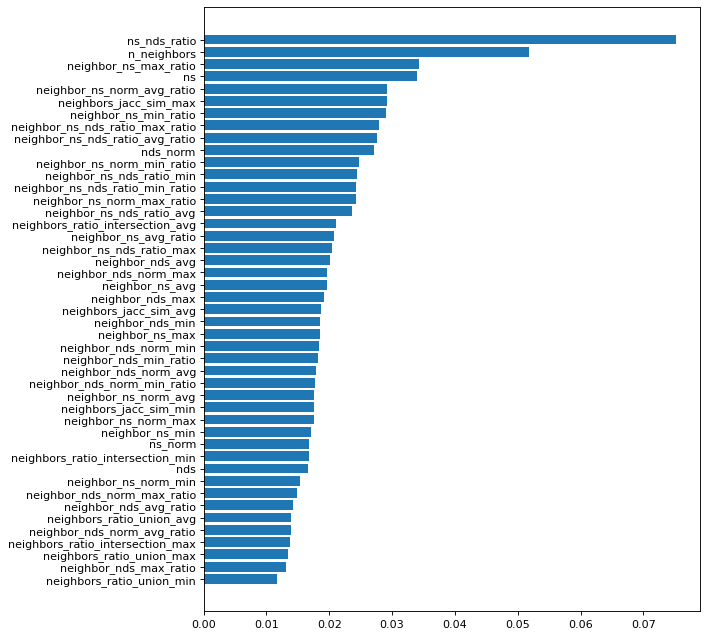

In [24]:
plt.figure(figsize=(8, 10), dpi=80)

plt.barh(np.array(features2use)[rf_clf.feature_importances_.argsort()], 
                                rf_clf.feature_importances_[rf_clf.feature_importances_.argsort()])
                                                                                                   
                                                                                   

- keep working on the machine learning baseline

- maybe include other metrics like complexity of the nodes, etc

- verify if order matters of the features - No as expected, it doesnt

- test this with more complex expansions (like random expansions)

In [25]:
metric_arr = defaultdict(list)

test_label_123 = test_props[7]
print(test_label_123)

tgt_feat_x, tgt_feat_y = get_props_features_xy(props_dict[test_label_123])

tgt_feat_x = np.round(tgt_feat_x,2)

tgt_prob = rf_clf.predict_proba(tgt_feat_x)[:,1]
tgt_pred = tgt_prob > 0.5

for m, m_func in metrics2check.items():
    try:
        if m == "precision_score":
            m_val = m_func(tgt_feat_y, tgt_pred, zero_division=0)
        elif m in ["accuracy_score", "balanced_accuracy_score", "f1_score", "recall_score"]:
            m_val = m_func(tgt_feat_y, tgt_pred)
        else:
            m_val = m_func(tgt_feat_y, tgt_prob)
    except Exception as e:
        print(m, m_func)
        raise e

    metric_arr[m].append(m_val)
    
metric_arr

t5lucas


defaultdict(list,
            {'accuracy_score': [0.8818181818181818],
             'average_precision_score': [0.8662834940477369],
             'balanced_accuracy_score': [0.8376623376623377],
             'f1_score': [0.7868852459016394],
             'precision_score': [0.8571428571428571],
             'recall_score': [0.7272727272727273],
             'roc_auc_score': [0.9464777646595828]})

In [26]:
print(test_label_123)
print()

for s, _pred, _prob in zip(props_dict[test_label_123]["steps"], tgt_pred, tgt_prob):
    print(s[0], s[1], "\t\t", s[4], "\t", _pred, _prob)

t5lucas

1 mp2 		 1 	 True 0.9
2 sylanbrc 		 1 	 True 0.6
3 ax-mp 		 1 	 True 0.8
4 ax-mp 		 1 	 True 1.0
5 ax-gen 		 1 	 False 0.0
6 syl 		 1 	 True 0.7
7 ax-mp 		 1 	 True 0.7
8 pm5.21nii 		 1 	 True 1.0
9 elex 		 0 	 False 0.0
10 adantl 		 0 	 False 0.0
11 elex 		 0 	 False 0.0
12 elab2g 		 0 	 False 0.0
13 anbi12d 		 0 	 False 0.0
14 eleq1 		 0 	 False 0.0
15 eleq1 		 0 	 False 0.0
16 df-in 		 0 	 False 0.0
17 bi1 		 0 	 False 0.0
18 simpl 		 0 	 False 0.0
19 biimpi 		 1 	 False 0.1
20 bicomi 		 0 	 True 0.8
21 bitr4i 		 1 	 True 0.9
22 3bitri 		 0 	 False 0.1
23 dfss 		 0 	 False 0.1
24 eqeq2i 		 0 	 False 0.0
25 df-in 		 0 	 False 0.0
26 abeq2 		 0 	 False 0.0
27 albii 		 0 	 False 0.0
28 pm4.71 		 0 	 False 0.0
29 ax-1 		 0 	 False 0.0
30 syl 		 1 	 True 0.9
31 alrimi 		 1 	 False 0.1
32 ax-17 		 0 	 True 0.7
33 syl6 		 1 	 True 0.9
34 mpd 		 1 	 True 0.6
35 syl5com 		 1 	 True 0.9
36 id 		 0 	 False 0.0
37 syl5com 		 1 	 False 0.3
38 id 		 0 	 False 0.0
39 3imtr4g 		 1 	 True 1

In [27]:
statement_probs = []

for s, pr, gt in zip(tgt_prop["steps"], tgt_pred, tgt_feat_y):
    if gt == 1:
        statement_probs.append((s[2], pr[1]))

statement_probs

NameError: name 'tgt_prop' is not defined

In [ ]:
sorted(statement_probs, key=lambda a: a[1])

talvez seja interessante comentar que partir de algo sumarizado para algo mais detalhado eh mais facil apra o estudante do que o contrario do ponto de vista de compreensao ja que para sumarizar para entender melhor o estudante em tese teria ja que ter um dominio do assunto.

preciso verificar porque provavelmente os labels estao vazando por meio da feature number of neighbors because the way we are expnading nodes. Expanding only the first depth will is likely to create a bipartite graph. The proper way to do this is to expand randomly.

Another thing is that the way we are working we cannot detect when we are supposed to have one step in between. This is not a big problem because our proposal here is to summarize (reduce size of presentation) of a proof. But nevertheless, it may also be a good idea to work by hidding steps to help our model generalize better and possible "learn" how to classify such things.